## 房价预测项目


#### 准备工作

In [61]:
# 基本包的导入
import numpy as np
import os

# 画图相关
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# 忽略警告
import warnings

In [62]:
plt.rcParams["axes.labelsize"] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [63]:
# 图片存储目录
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'end_to_end_project'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("保存图片:", fig_id)
    
    if tight_layout:
        plt.tight_layout()


warnings.filterwarnings(action='ignore', module='scipy', message='internal gelsd')

### 获取数据

In [64]:
HOUSING_PATH = os.path.join("datasets", "housing")

In [65]:
def loading_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [66]:
housing = loading_housing_data()

In [67]:
housing.head()  

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [68]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [69]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [70]:
housing.describe()  #针对数值类型做的计算描述，mean均值，std方差。

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


保存图片: attribute_histogram_plot


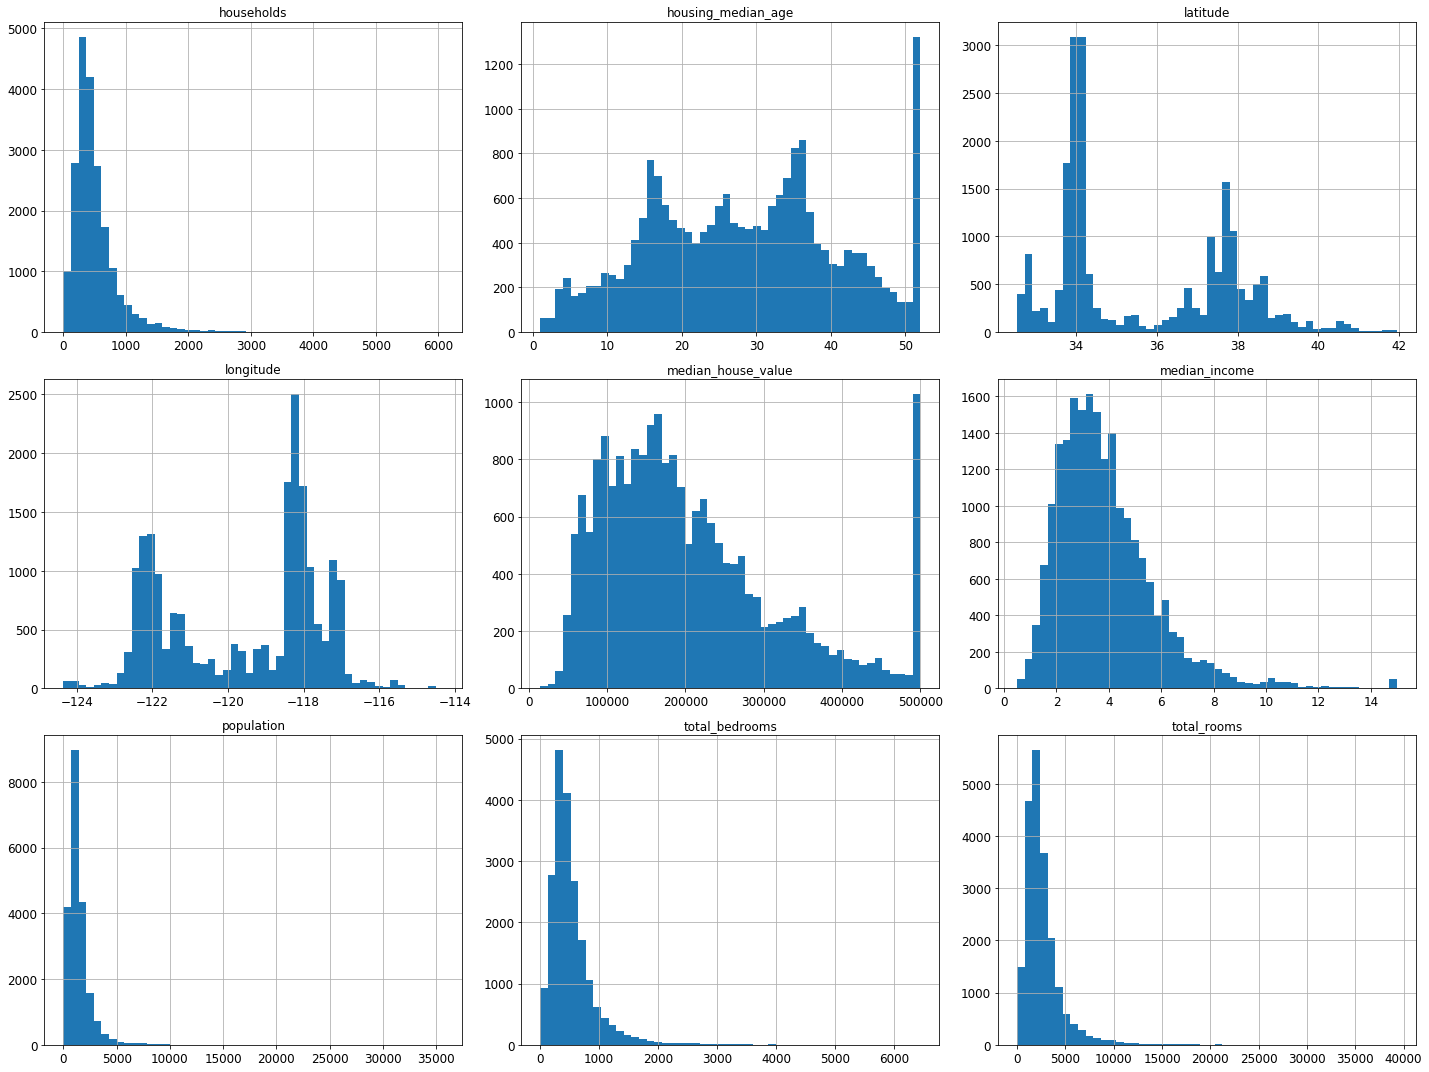

In [71]:
housing.hist(bins=50, figsize=(20, 15)) # 50条条状图
save_fig("attribute_histogram_plot")
plt.show()

In [72]:
# 随机因子，保持每次产生的随机数一样
np.random.seed(42)

In [73]:
# 图例使用，sklearn有更方便的函数：train_test_split()
def split_train_test(data, test_radio):
    shuffed_indices = np.random.permutation(len(data)) # 返回打乱后的数组
    test_set_size = int(len(data) * test_radio)
    test_indices = shuffed_indices[:test_set_size]
    train_indices = shuffed_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [74]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "trian + ", len(test_set), " test")

16512 trian +  4128  test


In [75]:
from zlib import crc32
def test_set_check(identifier, test_radio):
    return crc32(np.int16(identifier)) & 0xffffffff < test_radio * 2**32

In [76]:
def split_train_test_by_id(data, test_radio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_, test_radio))
    return data.loc[-in_test_set], data.loc[in_test_set]

In [77]:
import hashlib

In [78]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [79]:
# 添加index列
housing_with_id = housing.reset_index()

In [80]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [81]:
housing_with_id['id'] = housing["longitude"] * 1000 + housing["latitude"]

In [82]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [83]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [84]:

# sklearn
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [85]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


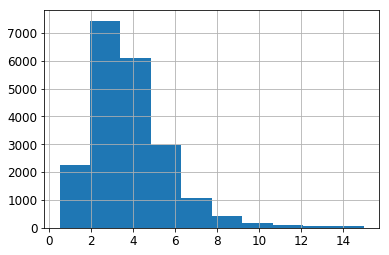

In [86]:
housing["median_income"].hist()

In [87]:
# 加限制
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5) # 向下取整

In [88]:
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [89]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

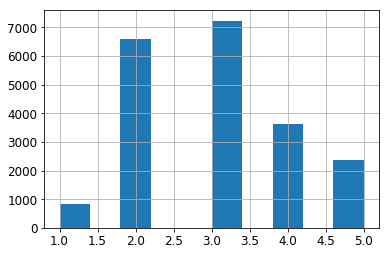

In [90]:
housing["income_cat"].hist()

In [91]:
from sklearn.model_selection import StratifiedShuffleSplit  # 分层抽样

In [92]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [93]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

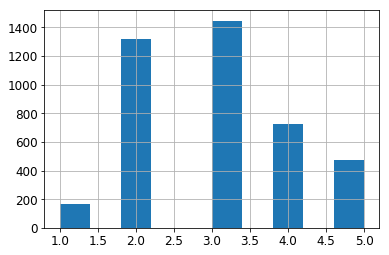

In [94]:
strat_test_set["income_cat"].hist()

In [95]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [96]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [97]:
# 分层抽样和随机抽样 对测试集的区别
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

In [98]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [99]:
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set)
}).sort_index()


In [100]:
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [101]:
compare_props  # 可以看到分层抽样集中的数据结构和数据集的基本一致，随机划分的就差很多

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


### 进一步探索，可视化数据

In [102]:
housing = strat_train_set.copy()

保存图片: bad_visualization_plot


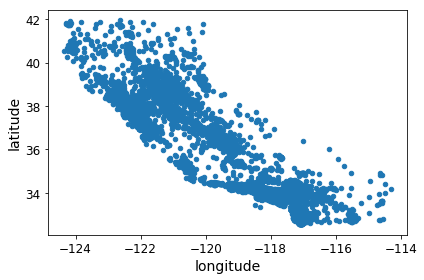

In [103]:
# 画出经纬度
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

保存图片: better_visualization_plot


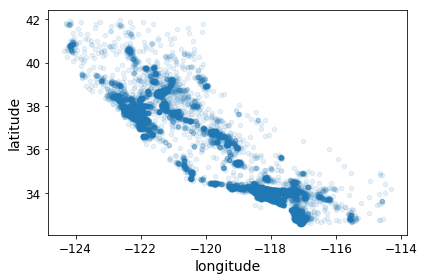

In [104]:
# 画出经纬度, 反应密集情况
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

保存图片: housing_prices_scatterplot


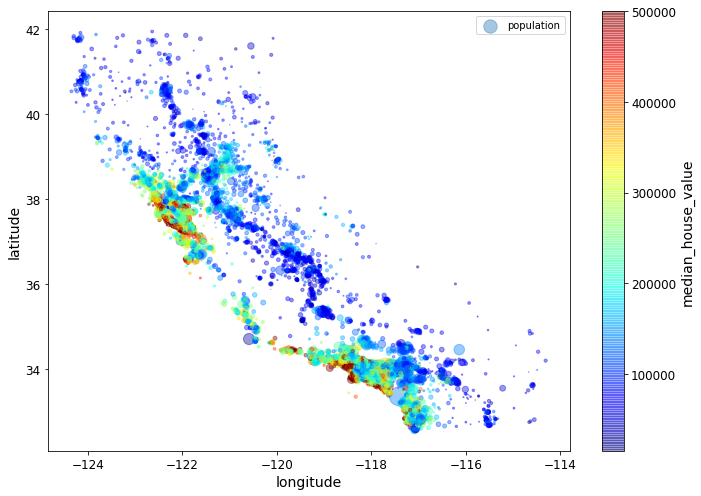

In [105]:
# 加上颜色密度信息
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
            s=housing["population"] / 100, label="population", figsize=(10, 7), 
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")